In [ ]:
#| default_exp curriculum

In [ ]:
#| export
import math
from functools import partial
from types import SimpleNamespace

import matplotlib.pyplot as plt
import torch

from looped_experiments.training import Callback

In [ ]:
from looped_experiments import utils
from looped_experiments.all import *

In [ ]:
cfg = get_config()
train = cfg.training
curr = train.curriculum

In [ ]:
show_config(train)

batch_size: 64
n_epoch: 50
train_steps: 10000
eval_steps: 1000
learning_rate: 0.0001
weight_decay: 0.0
save_every_steps: 10000
curriculum:
  dims:
    type: linear
    start: 5
    end: 20
    inc: 1
    interval: 5000
  points:
    type: linear
    start: 11
    end: 41
    inc: 2
    interval: 5000



In [ ]:
# | export
def linear_clm(cfg, steps):
    return torch.minimum(torch.tensor(cfg.end), cfg.start + steps // cfg.interval * cfg.inc)


def log_clm(cfg, steps, base=1.1):
    values = torch.zeros_like(steps)
    bins=torch.cat((torch.tensor([float("-inf")]),torch.arange(cfg.end - cfg.start)))
    for i, v in enumerate(cfg.interval*torch.cumsum(torch.pow(base, bins), 0)):
        values[steps >= v]= i*cfg.inc
    return torch.minimum(values+cfg.start, torch.tensor(cfg.end))


def sqrt_clm(cfg, steps):
    return torch.round((cfg.end - cfg.start) * torch.sqrt(steps / len(steps)) + cfg.start)


def cos_clm(cfg, steps):
    return torch.round((cfg.end - cfg.start)/2 * -torch.cos(steps / cfg.interval * cfg.inc) + (cfg.end + cfg.start)/2)


In [ ]:
# |export
class Curriculum:
    """Curriculum for training"""
    funcs = {
            'linear': linear_clm,
            'log': log_clm,
            'sqrt': sqrt_clm,
            'cos': cos_clm
            }
    
    def __init__(self, cfg, n_steps=10_000, clm_type='linear', clm_func=None, **kwargs):
        """Initialize the Curriculum class.

        Args:
            cfg (dict): The configuration for the curriculum.
            n_steps (int, optional): The total number of steps. Defaults to 10_000.
            clm_type (str, optional): The type of curriculum function. Used if `clm_func` is None. Defaults to 'linear'.
            clm_func (function, optional): The custom curriculum function. Defaults to None.
        """
        self.steps = torch.arange(0, n_steps, 1)
        f = clm_func or self.clm_func(clm_type)
        self.values = f(cfg, self.steps, **kwargs).type(torch.int32)
        

    @classmethod
    def clm_func(self, type: str):
        """Get the curriculum function based on the type."""
        return self.funcs[type]

    def __call__(self, step):
        return self.values[step-1].item()

    def show(self, ax=None, figsize=(12, 5)):
        if ax is None: _, ax = plt.subplots(figsize=figsize)
        ax.plot(self.steps, self.values)
        ax.grid()
        ax.set_xlabel('Steps'), ax.set_ylabel('Value')

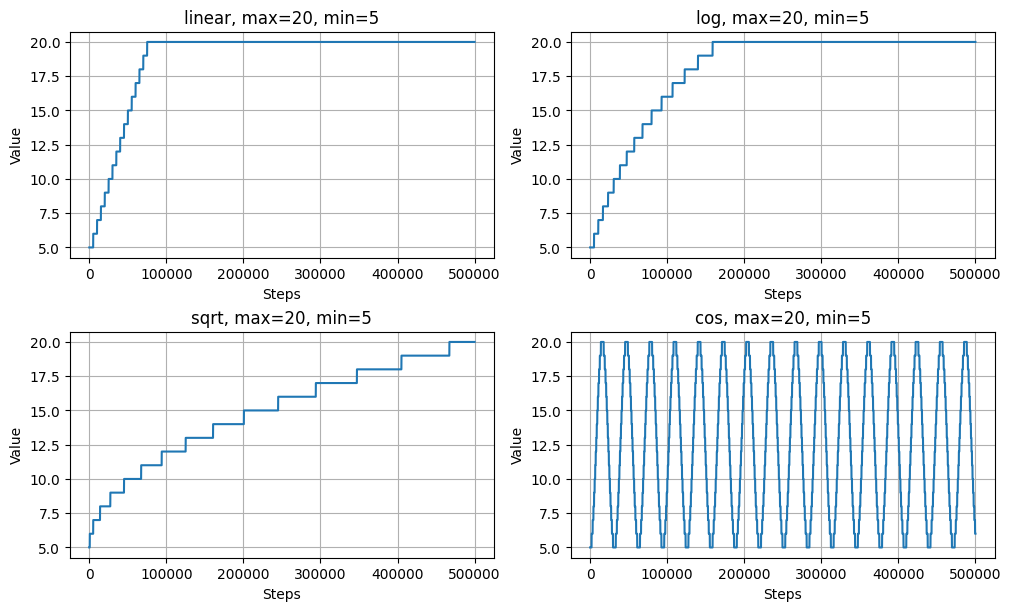

In [ ]:
cfg = curr.dims
c = partial(Curriculum, cfg=cfg, n_steps=train.n_epoch*train.train_steps)
axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout="constrained")[1]
for ax, f in zip(list(ax for axx in axes for ax in axx), Curriculum.funcs.keys()):
    cr = c(clm_type=f)
    cr.show(ax=ax)
    ax.set_title(f"{f}, max={cr.values.max().item()}, min={cr.values.min().item()}")

In [ ]:
# | export
class CurriculumCB(Callback):
    def __init__(self, curriculum_config, train_config):
        self.cfg = curriculum_config
        kwgs = lambda x: ({} if not hasattr(x, 'kwargs') else x.kwargs)
        self.curs = {k: Curriculum(v, n_steps=train_config.train_steps * train_config.n_epoch, clm_type=v.type, **kwgs(v))
                     for k, v in curriculum_config.items()}

    def update_task(self, learn, ds):
        ds.task.n_points = self.curs['points'](learn.train_step)
        n_dims = self.curs['dims'](learn.train_step)
        ds.task.truncated_dims = ds.task.n_dims - n_dims
        if hasattr(learn, 'stats'):
            learn.stats['n_points'] = ds.task.n_points
            learn.stats['n_dims'] = n_dims

    def after_batch(self, learn):
        if learn.model.training: self.update_task(learn, learn.dl_train.dataset)
        else: self.update_task(learn, learn.dl_valid.dataset)


class LoopCB(CurriculumCB):
    def update_model(self, learn):
        learn.model.n_loops = self.curs['loops'](learn.train_step)
        if hasattr(learn, 'stats'):
            learn.stats['n_loops'] = learn.model.n_loops

    def after_batch(self, learn): self.update_model(learn)